#Creating a dataset generator from TTS and noise

The idea consists on creating a generator that mixes voices from a [multiple-speaker TTS engine](https://colab.research.google.com/drive/18LESr4zVb5fxqyaqAnesC0JyLKKdHrir#scrollTo=j095gj9q-c4R) with [ambient noises](https://urbansounddataset.weebly.com/urbansound.html), generating audio samples to be used for training the MOTH architectures. The results of such artificial dataset is yet to be validated.

One issue here is that the output samples *can only* be generated in the same language as the TTS engine.

Each generated sample is going to be saved as a WAV file, with a name consisting of an id number and it's label, according to the following:

##`AAAAAA-BCD.wav`
`AAAAAA`: id number with zero padding

`B`: `bool` for the presence of speech

`C`: `bool` for the presence of multiple speakers

`D`: `bool` for the presence of the activation commmand



#Miscelania


In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Parameters
`duration`: duration in miliseconds\
`sample_rate`: sample rate in Hz\
`bit_depth`: bit depth in bits\
`channels`: number of channels

In [0]:
duration = 2000
sample_rate = 22050
bit_depth = 16
channels = 1

#Generator code

In [0]:
import os
import sys
import random
import numpy as np
import pandas as pd
import scipy
!pip install 'librosa==0.7.2'
import librosa as lib
import librosa.display as libdisp
import matplotlib.pyplot as plt
import IPython
from IPython.display import Audio
from google.colab import output
import time
import csv

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for librosa: filename=librosa-0.7.2-cp36-none-any.whl size=1612885 sha256=3a3921e65dc680525cab46e96462f7ad27261ea207482e8153a4e3bda20ee3ea
  Stored in directory: /root/.cache/pip/wheels/4c/6e/d7/bb93911540d2d1e44d690a1561871e5b6af82b69e80938abef
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [0]:
class SampleGenerator(object):
  def __init__(self, duration = 2000, sr = 22050, bd = 16, channels = 1):
    self.duration = duration
    self.sr = sr
    self.bd = bd
    self.channels = channels
    self.base_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET"
    self.generated_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/GENERATED"
    self.activation_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/ACTIVATION_MOCHILA"
    self.speech_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/VOXCELEB1/CUT"
    self.noise_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/NOISE"
    self.noise_files = []
    self.random_speech_files = []
    self.activation_files = []
    self.populate_sample_indexes()
    self.history_file = os.path.join(self.base_dir, 'history_C.csv')
    self.current_id = 0
    self.get_current_id(self.generated_dir)
    print('Generator successfully intialized. \nCurrent stats:')
    self.sample_counter()

  def get_current_id(self, dir):
    with open(self.history_file, 'r') as f:
      h = list(csv.reader(f))
      h.pop(0)
      if(len(h) > 0):
        h = np.array(h)
        h = h.T
        h = list(h[0][1:])
        h = [int(x) for x in h]
        self.current_id = max(h)
      else:
        self.current_id = 0

  def show_audio(self, audio_array, show_waveform=True, show_player=True, show_spectrogram=True, spec_type='mel'):
    if(show_player):
      IPython.display.display(Audio(audio_array, rate=self.sr))
    if(show_waveform):
      plt.figure()
      plt.title('Waveform')
      libdisp.waveplot(audio_array, alpha=0.8)
      plt.show()
    if(show_spectrogram):
      plt.figure()
      plt.title('Spectrogram - ' + spec_type)
      data_to_spec = lib.amplitude_to_db(np.abs(lib.stft(audio_array)), ref=np.max)
      libdisp.specshow(data_to_spec, y_axis=spec_type)
      print(data_to_spec.shape)
      #plt.imshow(data_to_spec)
      plt.show()

  def constrain_sample(self, insertion, position, duration = 2000, sr = 22050):
    #sample = np.zeros(shape=int((duration/1000)*sr), dtype=np.float32)
    size_diff = sr*int(duration/1000)-len(insertion)
    if size_diff >= 0:
      concat = np.concatenate(
            [np.zeros(position, dtype=np.float32), insertion,
            np.zeros(size_diff-position, dtype=np.float32)])
      return concat
    else:
    	return insertion[position:position+sr*int(duration/1000)+1]

  def detail_sample(self, id = -1, has_speech = True, has_multivoice = True, has_activation = True, spec_type = 'mel'):
    selection = None
    if id == -1:    # get a random sample
      with open(self.history_file, 'r') as f:
        h = csv.reader(f)
        h = list(h)
        h = h[1:]
        if has_speech:
          index = 0
          for i in h:
            if i[2] == "False":
              h.pop(index)
            index += 1
        else:
          index = 0
          for i in h:
            if i[2] == "True":
              h.pop(index)
            index += 1
        if has_multivoice:
          index = 0
          for i in h:
            if i[3] == "False":
              h.pop(index)
            index += 1
        if has_activation:
          index = 0
          for i in h:
            if i[4] == "False":
              h.pop(index)
            index += 1
        else:
          index = 0
          for i in h:
            if i[4] == "True":
              h.pop(index)
            index += 1
        selection = random.choice(h)
    else:
      with open(self.history_file, 'r') as f:
        h = list(csv.reader(f))
        h.pop(0)
        h = np.array(h)
        selection = h[list(h.T[0]).index(str(id))]
    noise_sample, _ = lib.core.load(selection[5])
    noise_sample = self.constrain_sample(noise_sample, int(selection[6]))
    combined_sample, _ = lib.core.load(selection[1])
    speech_sample = np.zeros(shape=int((self.duration/1000)*self.sr), dtype=np.float32)
    if selection[4] == 'True':
      speech_sample, _ = lib.core.load(selection[9])
      speech_sample = self.constrain_sample(speech_sample, int(selection[10]))
    elif selection[2] == 'True':
      speech_sample, _ = lib.core.load(selection[7])
      speech_sample = self.constrain_sample(speech_sample, int(selection[8]))
    # plot
    plt.figure("ID da amostra: " + selection[1][-14:-4], figsize=[12, 8], dpi=100)
    
    ax3 = plt.subplot(133)
    plt.subplots_adjust(wspace=0.2)
    data_to_spec = lib.amplitude_to_db(np.abs(lib.stft(combined_sample)), ref=np.max)
    libdisp.specshow(data_to_spec, y_axis=spec_type)
    ax1 = plt.subplot(131, sharex=ax3)
    plt.title("ID da amostra: " + selection[1][-14:-4])
    data_to_spec = lib.amplitude_to_db(np.abs(lib.stft(noise_sample)), ref=np.max)
    libdisp.specshow(data_to_spec, y_axis=spec_type)
    ax2 = plt.subplot(132, sharex=ax3)
    data_to_spec = lib.amplitude_to_db(np.abs(lib.stft(speech_sample)), ref=np.max)
    libdisp.specshow(data_to_spec, y_axis=spec_type)
    plt.show()
    print(data_to_spec.shape)
    self.show_audio(combined_sample, show_waveform = False, show_spectrogram = False)

  def sample_counter(self):
    files = os.listdir(self.generated_dir)
    files.sort()
    has_speech_count = 0
    has_activation_count = 0
    has_multivoice_count = 0
    has_only_noise = 0
    for f in files:
      f = f[:-4]
      if(f[-3] == '1'):
        has_speech_count += 1
        if(f[-1] == '1'):
          has_activation_count += 1
        if(f[-2] == '1'):
          has_multivoice_count += 1
      else:
        has_only_noise += 1
    total = len(files)
    if total == 0:
      print('{:17}'.format('TOTAL') + '{:6d}'.format(total))
    else:
      print('{:17}'.format('NOISE') + '{:6d}'.format(len(self.noise_files)))
      print('{:17}'.format('RANDOM') + '{:6d}'.format(len(self.random_speech_files)))
      print('{:17}'.format('ACTIVATION') + '{:6d}'.format(len(self.activation_files)))
      print('')
      print('{:17}'.format('GENERATED') + '{:6d}'.format(total) + '   {:4.1f}%'.format(100.0))
      print('{:17}'.format('  NOISE') + '{:6d}'.format(has_only_noise) + '   {:4.1f}%'.format((has_only_noise*100/total)))
      print('{:17}'.format('  SPEECH') + '{:6d}'.format(has_speech_count) + '   {:4.1f}%'.format((has_speech_count*100/total)))
      print('{:17}'.format('     RANDOM') + '{:6d}'.format(has_speech_count-has_activation_count) + '   {:4.1f}%'.format(((has_speech_count-has_activation_count)*100/has_speech_count)))
      print('{:17}'.format('     ACTIVATION') + '{:6d}'.format(has_activation_count) + '   {:4.1f}%'.format((has_activation_count*100/has_speech_count)))
      print('{:17}'.format('     MULTIVOICE') + '{:6d}'.format(has_multivoice_count) + '   {:4.1f}%'.format((has_multivoice_count*100/has_speech_count)))

  def populate_sample_indexes(self):
    self.noise_files = os.listdir(self.noise_dir)
    self.random_speech_files = os.listdir(self.speech_dir)
    self.activation_files = os.listdir(self.activation_dir)

  def get_audio_file(self, sample_type):
    """sample type: speech, activation or noise"""
    
    filepath = ""
    if sample_type == "speech":  
      filepath = os.path.join(self.speech_dir, random.choice(self.random_speech_files))
    if sample_type == "activation":
      filepath = os.path.join(self.activation_dir, random.choice(self.activation_files))
    if sample_type == "noise":
      filepath = os.path.join(self.noise_dir, random.choice(self.noise_files))
    audio = lib.core.load(filepath, sr=self.sr)
    return audio[0], audio[1], filepath

  def get_random_sample(self, speech = True, multivoice = True, activation = True, blank = True, start_offset = 0, end_offset = 0):
    files = os.listdir(self.generated_dir)
    end_offset = -len(files) if end_offset == 0 else end_offset
    files = files[start_offset:-end_offset]
    filepath = ''
    if not speech:
      for i in files:
        if(i[-7] == '1'):
          files.remove(i)
    if not multivoice:
      for i in files:
        if(i[-6] == '1'):
          files.remove(i)
    if not activation:
      for i in files:
        if(i[-5] == '1'):
          files.remove(i)
    if not blank:
      for i in files:
        if(i[-7] == '0'):
          files.remove(i)
    sample_file = random.choice(files)
    print(os.path.join(self.generated_dir, sample_file))
    sample = lib.core.load(os.path.join(self.generated_dir, sample_file), sr=self.sr)
    self.show_audio(sample[0])

  def insert_audio(self, base, insertion, show_output=False, insertion_gain=1):
    size_diff = len(base)-len(insertion)
    chosen_position = 0
    if size_diff <= 0: # means insertion is longer
      chosen_position = random.randint(0, -size_diff)
      insertion = insertion[chosen_position:chosen_position+len(base)]
      base = np.add(base, insertion)/2
    else:
      chosen_position = random.randint(0, size_diff)
      concat = np.concatenate(
          [np.zeros(chosen_position, dtype=np.float32), insertion*insertion_gain,
          np.zeros(size_diff-chosen_position, dtype=np.float32)])
      base = np.add(base, concat)/2
      if show_output:
        self.show_audio(base)
    return base, chosen_position

  def distortion_generator(self, source, sr, change_pitch=True, slow_down=True, show_output=False):
    distorted = source
    if(change_pitch):
      distorted = lib.effects.pitch_shift(distorted, sr, random.randint(-1,+2))
    if(slow_down):
      distorted = lib.effects.time_stretch(distorted, random.randint(75,100)/100)
    if show_output:
      self.show_audio(distorted)
    return distorted

  def save_output_file(self, audio, sr, has_speech, has_multivoice, has_activation, show_output=False, extension='.wav'):
    filename = f'{self.current_id:06}'
    if not has_speech:
      filename += '-000' + extension
    else:
      filename += '-1'
      filename += '1' if has_multivoice else '0'
      filename += '1' if has_activation else '0'
      filename += extension
    if(show_output):
      print("'" + filename + "' saved successfully.")
    lib.output.write_wav(os.path.join(self.generated_dir, filename), audio, sr)
    return filename

  def audio_sample_generator(self,
                             n=1,
                             put_speech=None,
                             put_multivoice=None,
                             put_activation=None,
                             insert_noise=True,
                             insert_distortion=True,
                             activation_gain=1,
                             speech_gain=1,
                             noise_gain=1,
                             extra_voice_gain=1,
                             max_extra_voices=2,
                             show_output=False):
    start_time = time.time()
    samples_to_generate = n
    count = 0
    with open(os.path.join(self.base_dir, 'history.csv'), 'a') as f:
      writer = csv.writer(f)
      for i in range(samples_to_generate):
          has_speech = random.choice([True, False, False, False]) if put_speech == None else put_speech
          has_multivoice = random.choice([True, False]) if put_multivoice == None else put_multivoice
          has_activation = random.choice([True, False]) if put_activation == None else put_activation
          sample = np.zeros(shape=int((self.duration/1000)*self.sr), dtype=np.float32)
          noise_sample, _, noise_filepath = self.get_audio_file('noise')
          sample, noise_position = self.insert_audio(sample, noise_sample, insertion_gain=noise_gain)
          speech_filepath = ''
          speech_position = 0
          activation_filepath = ''
          activation_position = 0
          if has_speech:
            if has_activation:
              activation_sample, _, activation_filepath = self.get_audio_file('activation')
              if(insert_distortion):
                activation_sample = self.distortion_generator(activation_sample, self.sr)
              sample, activation_position = self.insert_audio(sample, activation_sample, insertion_gain=activation_gain)
            else:
              speech_sample, _, speech_filepath = self.get_audio_file('speech')
              if(insert_distortion):
                speech_sample = self.distortion_generator(speech_sample, self.sr)
              sample, speech_position = self.insert_audio(sample, speech_sample, insertion_gain=speech_gain)
            if has_multivoice:
              n_extra_voices = random.randint(1, max_extra_voices+1)
              for voice in range(n_extra_voices):
                extra_voice, _, _ = self.get_audio_file('speech')
                sample, _ = self.insert_audio(sample, extra_voice, insertion_gain=extra_voice_gain)
          if show_output:
            self.show_audio(sample)
          filename = self.save_output_file(sample, self.sr, has_speech, has_multivoice, has_activation)
          writer.writerow([self.current_id,
                          os.path.join(self.generated_dir, filename),
                          str(has_speech),
                          str(has_multivoice),
                          str(has_activation),
                          noise_filepath,
                          noise_position,
                          speech_filepath,
                          speech_position,
                          activation_filepath,
                          activation_position])
          self.current_id += 1
          current_time = float(time.time() - start_time)
          count += 1
          output.clear('status_text')
          with output.use_tags('status_text'):
            if(current_time > 2*60*60):
              print("Progress: {:5d}/{:5d} - {:6.2f}% | Last: {} | Elapsed: {:5.1f} h   | avg: {:4.2f} s".format(i, samples_to_generate, (i*100)/samples_to_generate, filename, current_time/(60*60), current_time/count))
            elif current_time > 2*60:
              print("Progress: {:5d}/{:5d} - {:6.2f}% | Last: {} | Elapsed: {:5.1f} min | avg: {:4.2f} s".format(i, samples_to_generate, (i*100)/samples_to_generate, filename, current_time/60, current_time/count))
            else:
              print("Progress: {:5d}/{:5d} - {:6.2f}% | Last: {} | Elapsed: {:5.1f} s   | avg: {:4.2f} s".format(i, samples_to_generate, (i*100)/samples_to_generate, filename, current_time, current_time/count))
    if(current_time > 2*60*60):
      print("\nTask completed successfully in {:.1f} hours.\nCurrent stats:".format(float(current_time)/(60*60)))
    elif current_time > 2*60:
      print("\nTask completed successfully in {:.1f} minutes.\nCurrent stats:".format(float(current_time)/(60)))
    else:
      print("\nTask completed successfully in {:.1f} seconds.\nCurrent stats:".format(float(current_time)))

    self.sample_counter()

In [0]:
generator = SampleGenerator()

Generator successfully intialized. 
Current stats:
NOISE              6526
RANDOM            17973
ACTIVATION          355

GENERATED         58293   100.0%
  NOISE               0    0.0%
  SPEECH          58293   100.0%
     RANDOM       29254   50.2%
     ACTIVATION   29039   49.8%
     MULTIVOICE       0    0.0%


In [0]:
generator.current_id = 58293

In [0]:
generator.audio_sample_generator(n=75000-58293, put_multivoice=False, put_speech=True)

Progress: 16706/16707 -  99.99% | Last: 074999-100.wav | Elapsed: 114.2 min | avg: 0.41 s



Task completed successfully in 114.2 minutes.
Current stats:
NOISE              6526
RANDOM            17973
ACTIVATION          355

GENERATED         75004   100.0%
  NOISE               0    0.0%
  SPEECH          75004   100.0%
     RANDOM       37662   50.2%
     ACTIVATION   37342   49.8%
     MULTIVOICE       0    0.0%


In [0]:
generator.audio_sample_generator(n=50001, put_multivoice=False, put_activation=False)

NameError: ignored

/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/GENERATED/006697-101.wav


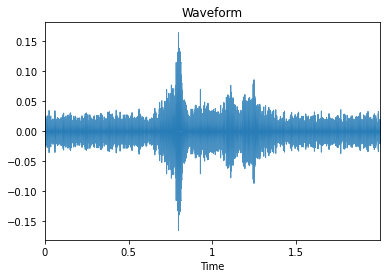

(1025, 87)


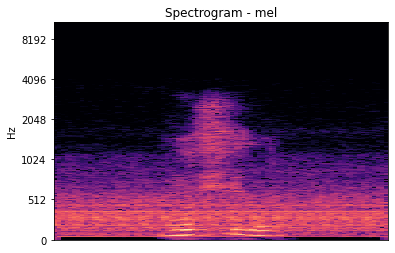

In [0]:
generator.get_random_sample(speech=True)

In [0]:
 from time import sleep

for i in range(1000):
  samples_to_generate = 1000
  filename = "arroz"+str(i)+".wav"
  print("Progress: {:5d}/{:5d} - {:6.2f}% | Last: {}".format(i, samples_to_generate, (i*100)/samples_to_generate, filename), end='\r', flush=True)

In [0]:
import time

start = time.time()
print("hello")
end = time.time()
print(end - start)

hello
0.0001652240753173828


In [0]:
input_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/VOXCELEB1"
output_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/VOXCELEB1/CUT"
sr = 22050
duration = 2
files = os.listdir(input_dir)
print(len(files))
for filepath in files:
  if(filepath[-4:] == '.wav'):
    big_audio, sr = lib.core.load(os.path.join(input_dir, filepath), sr=sr, mono=True)
    print(filepath, int(len(big_audio)/(sr*duration)))
    audios = np.array_split(big_audio, int(len(big_audio)/(sr*duration)))
    id = 0
    for audio in audios:
      lib.output.write_wav(os.path.join(output_dir, filepath[:-4] + "-" + str(id) + '.wav'), audio, sr)
      id += 1

In [0]:
with open("/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/history.csv", 'r') as f:
  h = np.array(list(csv.reader(f)))
  print(h)
  print(h.T)

[['filename' 'has_speech' 'has_multivoice' 'has_activation'
  'noise_filepath' 'noise_position' 'speech_filepath' 'speech_position'
  'activation_filepath' 'activation_position']]
[['filename']
 ['has_speech']
 ['has_multivoice']
 ['has_activation']
 ['noise_filepath']
 ['noise_position']
 ['speech_filepath']
 ['speech_position']
 ['activation_filepath']
 ['activation_position']]


In [0]:
input_dir = "/content/drive/My Drive/Eng Mecatrônica/5o Ano/TCC/DATASET/ACTIVATION_MOCHILA"
filepath = os.path.join(random.choice(os.listdir(input_dir)))

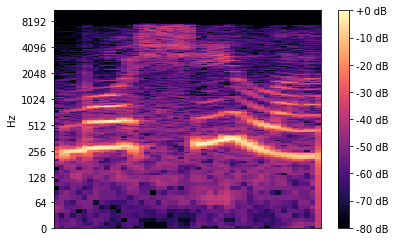

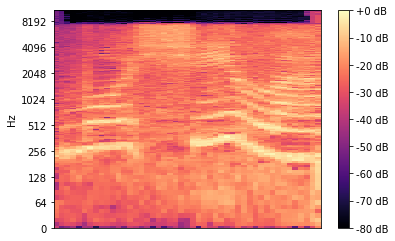

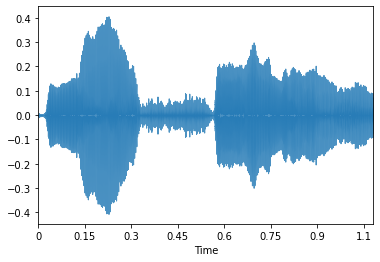

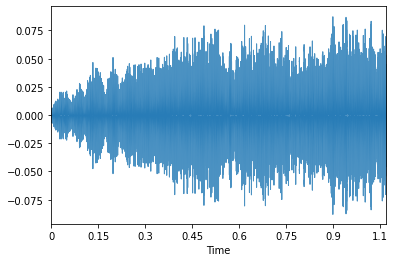

In [0]:
audio, sr = lib.core.load(os.path.join(input_dir, filepath), sr=22050, mono=True)
audio_b = lib.feature.melspectrogram(audio*2, sr=sr, power=1)
audio_b = lib.pcen(audio_b)
audio_b = lib.feature.inverse.mel_to_audio(audio_b)

data_to_spec = lib.amplitude_to_db(np.abs(lib.stft(audio)), ref=np.max)
plt.figure()
libdisp.specshow(data_to_spec, y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.figure()
data_to_spec = lib.amplitude_to_db(np.abs(lib.stft(audio_b)), ref=np.max)
libdisp.specshow(data_to_spec, y_axis='log')
plt.colorbar(format='%+2.0f dB')

plt.figure()
libdisp.waveplot(audio*2, alpha=0.8)

plt.figure()
libdisp.waveplot(audio_b, alpha=0.8)
IPython.display.display(Audio(audio, rate=sr))
IPython.display.display(Audio(audio_b, rate=sr))

In [0]:
(a = np.array([0.1, 0.2, 0.4])
a*2

array([0.2, 0.4, 0.8])

In [0]:
lib.feature.